In [24]:
import torch
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import numpy
import pandas
from typing import Optional
from tqdm import tqdm

In [25]:
class DropNorm(nn.Module):
	def __init__(self, size_in, size_out):
		super().__init__()

		self.size_in, self.size_out = size_in, size_out

		self.weights = nn.Parameter(torch.Tensor(size_out, size_in))  # nn.Parameter is a Tensor that's a module parameter.
		self.bias = nn.Parameter(torch.Tensor(size_out))

		self.linear1 = nn.Linear(size_in, size_out)
		self.activation = nn.ReLU(inplace=True) # inplace = don't use extra memory

		self.drop_probability = 0.5  # We can take as argument but this question doesn't requires it.
		
	
	def forward(self, batch):
		# First dim = batch size
		# Second dim = sample

		mask = torch.bernoulli(batch, self.drop_probability)  # 0 and 1 distrobution
		Y = mask * batch  # Apply mask to batch

		return Y

model = nn.Sequential(
	nn.Linear(784, 2049),
	nn.ReLU(),

	DropNorm(2049, 2049),
	nn.ReLU(),

	nn.Linear(2049, 20),
	nn.Softmax()
)

# model = nn.Sequential(
# 	DropNorm(784, 784),

# 	nn.Linear(784, 2049),
# 	nn.ReLU(),

# 	nn.Linear(2049, 512),
# 	nn.ReLU(),

# 	nn.Linear(512, 20),
# 	nn.Softmax()
# )

In [26]:
batch_size = 600


dataset = torchvision.datasets.FashionMNIST(root="/22961", train=True, download=True, transform=torchvision.transforms.PILToTensor())
dataloader = DataLoader(dataset, batch_size=batch_size)

print("num of samples:", len(dataset))
batches=len(dataloader)
print("batch size: ", batch_size)
print("num of batches:", batches)
print("image size:", dataset[0][0].shape)

num of samples: 60000
batch size:  600
num of batches: 100
image size: torch.Size([1, 28, 28])


In [27]:
loss_func=torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [28]:
def iterate_batch(idx):
	imgs, labels = next(iter(dataloader))
	imgs = imgs.flatten(start_dim=1)

	optimizer.zero_grad()
	y_model=model(imgs.float())

	loss=loss_func(y_model,labels)
	loss.backward()
	optimizer.step()

	predicted_labels = y_model.argmax(dim=1)
	acc = (predicted_labels == labels).sum()/len(labels)
	return loss.detach(), acc.detach()

In [29]:
# Computing on GPU (if possible)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

get_default_device()

device(type='cpu')

In [30]:

batch_loss=torch.zeros(batches)
batch_acc=torch.zeros(batches)
for idx in tqdm(range(batches)):
	batch_loss[idx], batch_acc[idx] = iterate_batch(idx)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Shlomi\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 100/100 [00:11<00:00,  8.55it/s]


Text(0.5, 0, 'Epoch Number')

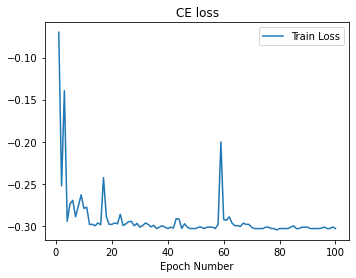

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(range(1,batches+1), batch_loss,label="Train Loss")
plt.title("CE loss")
plt.legend()
plt.xlabel("Epoch Number")